Kyle Polansky (KPP446), Brian White (BCW824)

# <p style="text-align: center;">EE 461P: Data Science Principles</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 60</p>
## <p style="text-align: center;">Due: Tuesday, October 24th, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1 - Gradient Descent (5+8+2=15pts)

In this question you will implement vanilla SGD and an adaptive gradient update technique called Adagrad. In addition, you will also implement ridge regularization. 

1.) Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1*x_1 + w_2*x_1*x_2 + w_3*x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, submit that as a separate file and make a reference to it in your notebook or include the image in your notebook.

w(0) = w(0) - learning_rate * error

w(n>0) = w - learning_rate * error * x(n>0)

2.) Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1*x_1 + w_2*x_1*x_2 + w_3*x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'SGD' or 'adagrad' (Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 10 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch count (10 epochs) for the best 2 combinations of learning_rate and regularization for both SGD and Adagrad. ie you should have 2 plots of MSE and parameter updates for SGD and adagrad each. Report the MSE at the end of 10 epochs for all 4 combinations.

In [294]:
class SGD:
    def __init__(self, learning_rate, regularization_constant, n_epochs):
        self.rate = learning_rate
        self.reg = regularization_constant
        self.epochs = n_epochs
    
    def fit(self, X, y, update_rule):
        self.weights = [0 for i in range(len(X.columns)+1)] #one coef for each column of x, plus one for w0
        for epoch in range(self.epochs):
            sum_error = 0
            for row in range(len(X)):
                error = self._error(X.loc[row,:], y[row])
                sum_error += error**2
                self.weights[0] = self.weights[0] - self.rate * error #update w0
                for w in range(0, len(self.weights)-1): #update the rest of the weights
                    self.weights[w] = self.weights[w] - self.rate * error * X.loc[row,:][w]
                    
    #x is single row to predict y value of
    def predict(self, x):
        y_pred = self.weights[0]
        for w in range(1, len(x)):
            y_pred += self.weights[w] * x[w]
        return y_pred
    
    def _error(self, x, y):
        y_pred = self.predict(x)
        return y_pred - y
    
    def mse(self, X, y):
        sum_squared_error = 0
        for row in range(len(X)):
            sum_squared_error += self._error(X.loc[row,:], y[row])**2
        return sum_squared_error/len(X)
    
    def rmse(self, X, y):
        import math
        mse = self.mse(X,y)
        print(mse)
        return math.sqrt(mse)

In [270]:
import pandas as pd
data = pd.read_csv('samples.csv')
data.head()

,Unnamed: 0,y,x_1,x_2
0,0,-17.603120,9.734662,-2.377557
1,1,37.380085,0.519089,4.286200
2,2,18.357846,3.125776,0.451422
3,3,16.418092,1.175596,1.160180
4,4,46.589494,5.469643,1.615456


In [271]:
X = data.loc[:,'x_1':]
y = data['y']

In [297]:
def grid_search(X, y, rates, regs, n_epochs, update_rule):
    best_rmse = -1
    best_weights = None
    best_params = None
    for rate in rates:
        for reg in regs:
            for epochs in n_epochs:
                sgd = SGD(rate, reg, epochs)
                sgd.fit(X,y,update_rule)
                rmse = sgd.rmse(X,y)
                if best_rmse == -1 or rmse < best_rmse:
                    best_rmse = rmse
                    best_weights = sgd.weights
                    best_parmas = [rate, reg, epochs]
    return (best_rmse, best_weights, best_params)

In [290]:
rates = [.0001, .001, .01, 0.1, 1, 10, 100]
regs = [0,10,100]
n_epochs = [10]

In [ ]:
grid_search(X, y, rates, regs, n_epochs, 'SGD')

523.07338442
523.07338442
523.07338442
570.048434214


3.) Based on the experiments, answer the following:

1. Which of the 2 techniqes allows for larger initial setting of the learning_rate? Why?
2. What would a drawback of adagrad be? How could this be fixed? (Hint: Adadelta)

# Notes on Adagrad
Adagrad (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. A cache is maintained that holds the sum of squares of all gradients upto the current update. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = cache + (gradients^2)
2. weights = weights + ((learning_rate)/sqrt(cache+1e-6))*gradients

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

# 2. (6+4=10 pts) Tensor Playground
Visit http://playground.tensorflow.org for this problem

A. From the far right, select "Regression" as the problem type, and select the 2nd of the two data sets ( the right one ).  

   i) What sort of test / training loss do you get if you run it for 200 epochs with the following learning rates: .3, .01 and .003 ?  What if you run it for 1000 epochs with these learning rates?  Leave all other values at their defaults ( test/training ratio 50%, Noise 0, Batch Size 10, using Tanh activation function, and No Regularization )
   
   ii) Keeping learning rate at .3, Activation at Tanh, with all others at their defaults, and running for 200 epochs.  
     What sort of test/train loss can you achieve using only 1 neuron in the first hidden layer.  What about for 2,3 or 8 neurons?  Provide screen shots of output layer and comment on how the different output fits look and compare with one another.

   iii)Now keeping learning rate at .03 with all others at their defaults, and running for 200 epochs.  
       Compare how the activation functions affect the ouput ( ReLU, Sigmoid, Tanh, Linear ). Provide screen shots of output results and comment.


B. Neural Nets can fit anything.  Now reset to the initial defaults, and select "Classification" as the problem type, and from the Data section, select the bottom right "Spriral" data set.  With the idea of trying to minimize training/testing error, provide solutions to the problem for the following 2 scenarios.  i) Using just the first 2 inputs ( as per default ) and ii) Using all 7 of the inputs.  You may use as many layers as you want, whatever activation, however man neurons.  Provide screen shots which show your full network, output and parameters. Briefly justify your decisions, and comment on difficulties/tradeoffs, what helps/what doesn't,etc. 

## ANSWER

A.i) Running with a .3 learning rate, an accurate solution is found very quickly and at epoch 200, blue is the dominate color. At .01, the solution takes a bit longer to stabilize and orange/blue are fairly symmetric with uncertainty inbetween. With a .003 learning rate, the model does not have enough data by epoch 200 to make any strong predictions.

At epoch 1000, the .03 learning rate does not develop any farther, the model stays stable. At .01, There are no major differences, although the top and bottom of the graph have blue and orange respectivly when they were orange and blue before. The dots in those regions are white, so these points are insignificant given the training data. At a learning rate of .003, the model forms "banded" groupings at a 45 degree angle rather than the grid pattern that the other learning rates formed.

A.ii)

1 neuron: .044/.045 test/training loss. Output confidence is really low and with 1 neuron, essentially "cuts" the datapoints in half.

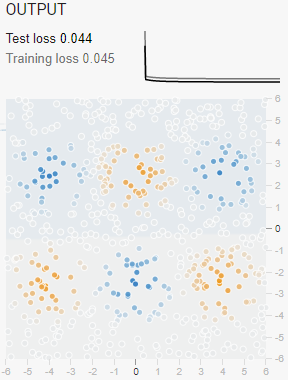

In [3]:
from IPython.display import Image
Image("images/2.A.ii 1 neuron.png")

2 neurons: .031/.035 test/training loss. With 2 neurons, we see 2 bands at a near 45 degree angle that are able to capture most of the data.

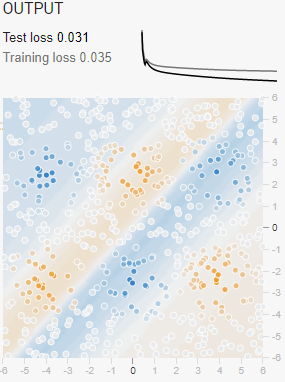

In [5]:
from IPython.display import Image
Image("images/2.A.ii 2 neurons.png")

3 neurons: .019/.019 test/training loss. This is actually the best combination used in this test. There are triangle slices that group each of the 6 clumps of data.

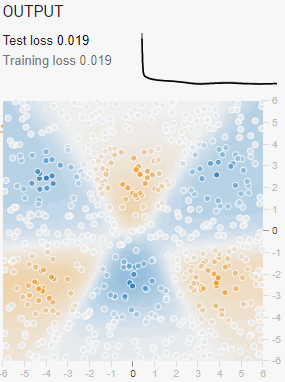

In [6]:
from IPython.display import Image
Image("images/2.A.ii 3 neurons.png")

8 neurons: .022/.021 test/training loss. Perhaps counter-intuitively, using 8 neurons seemed to perform worse than 3 neurons. It appears that the last 2 neurons used were small horizontal lines covering the top and bottom of the dataset. Since no data lives here, it it likely that any weights assigned to these neurons had a negative effect on the model.

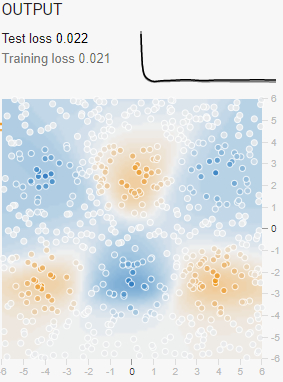

In [8]:
from IPython.display import Image
Image("images/2.A.ii 8 neurons.png")

A.iii)

ReLU: .046/.044 test/training loss. This activation seems to have captured the top left clump of data, correctly as blue, but the other data seems to be loosly classified as orange.

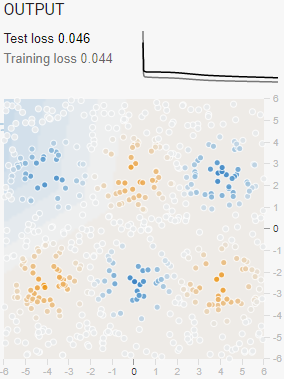

In [10]:
from IPython.display import Image
Image("images/2.A.iii relu.png")

Tanh: .023/.020 test/training loss. This activation performed significantly better than the others. Additionally, looking at the loss output graph, it can be seen that this activation gets a fairly accurate model from the start and slowly improves from there.

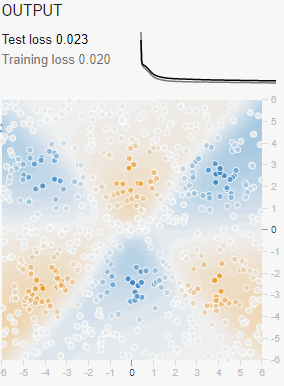

In [11]:
from IPython.display import Image
Image("images/2.A.iii tanh.png")

Sigmoid: .047/.052 test/training loss. This activation seems to have classified all the top groups as blue and all the bottom groups as orange, which is about 2/3 correct. It can be seen from the loss graphs that this function improves seemingly lineraly, so perhaps if ran for more epochs, the output would have looked better.

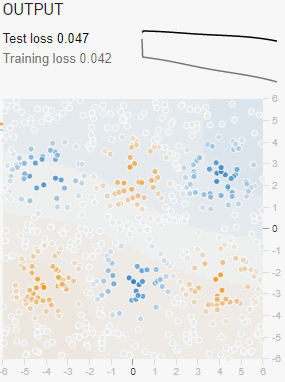

In [12]:
from IPython.display import Image
Image("images/2.A.iii sigmoid.png")

Linear: .048/.044 test/training loss. This activation created an angled model similar to the 2 neuron tanh graph in part 2. However, this seems to have a distinct blue/orange side instead of multiple bands together. Consequently, this model classification isn't very accurate. On top of that, the output graph appears to be flatlined, meaning that more training would not improve the model.

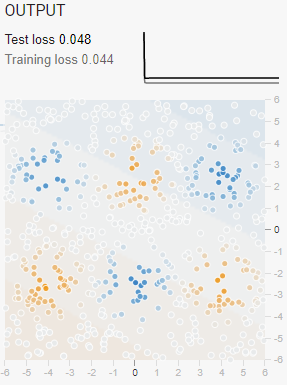

In [13]:
from IPython.display import Image
Image("images/2.A.iii linear.png")

B.i) The screenshot below shows the best parameters we could find. These paramters were found through a lot of trials, but it was pretty obvious from the start that a linear model wasn't going to work. We also didn't have much luck with the Sigmoid model. Tanh worked better, but we couldn't get it to fit quite as nice as ReLU. In genearl, we found that more neurons at the beginning worked best to capture all the major data trends, and then tapering them off at the end worked best. The default learning speed seemed to perform good enough, slower than that and the simulation ran for a really long time, and faster learning speeds would often diverge.

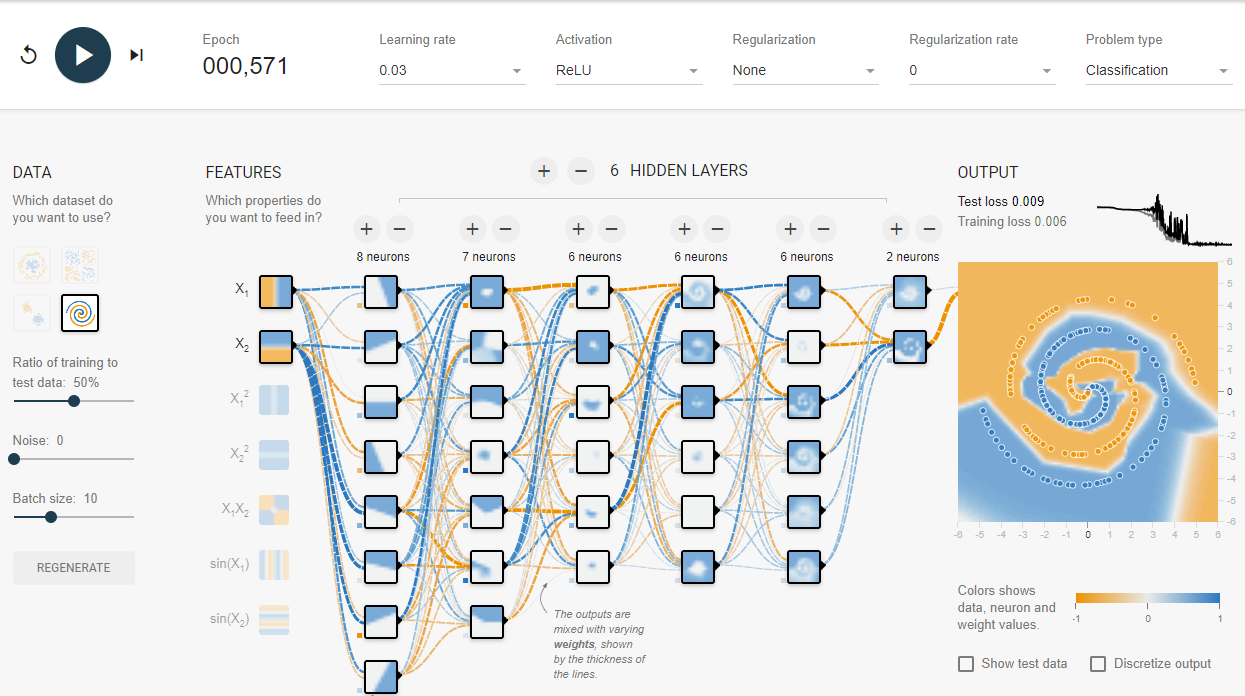

In [16]:
from IPython.display import Image
Image("images/2.B.i settings.png")

B.ii) The screenshot below shows the best parameters we could find using all the available features. The settings are very similar to our 2-feature model above. The only difference is a removed neuron in hidden layers 2, 4 and 5. These were found by trial and error, using the 2-feature settings as a starting point.

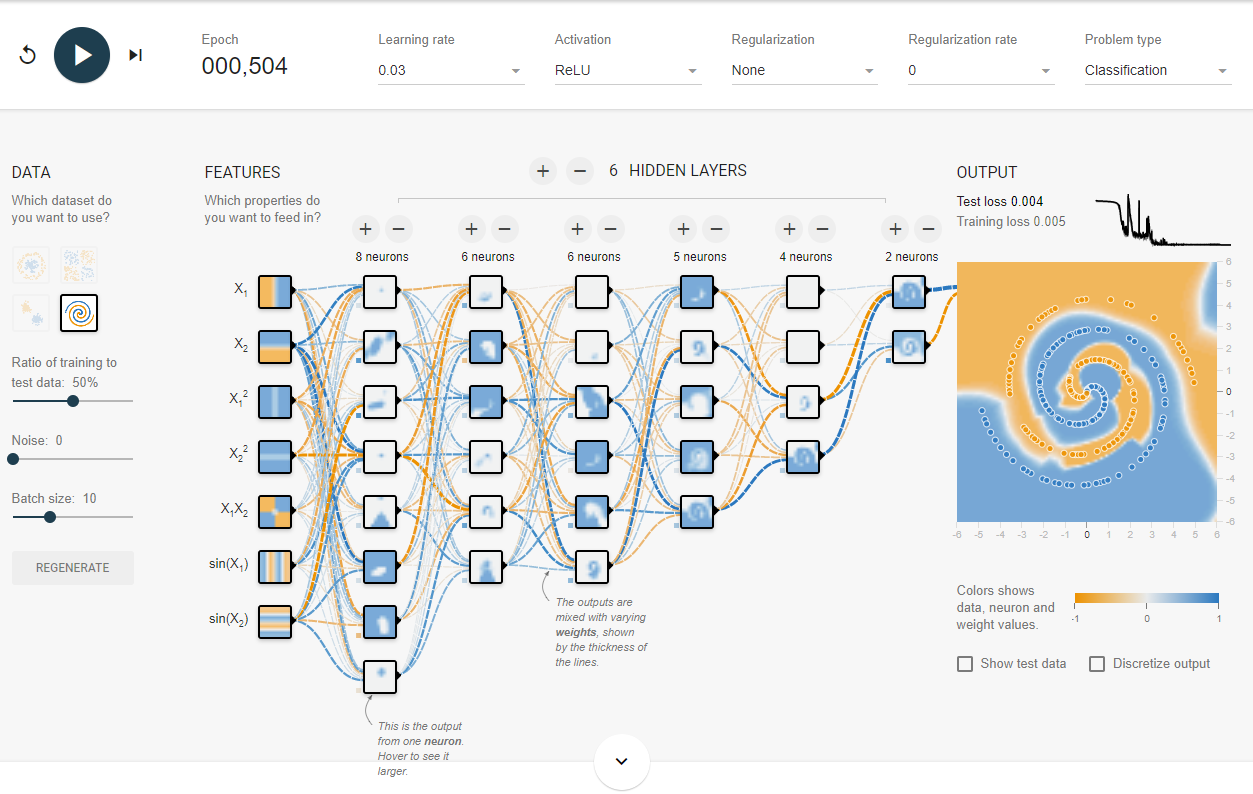

In [17]:
from IPython.display import Image
Image("images/2.B.ii settings.png")

# Question 3: Multi-layer Perceptron Regressor (15 points)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the Appliances energy prediction dataset for this problem https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 42** and **test_size = 0.33**.
Make sure you have 56 variables and one target variable.

In [209]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

from sklearn import datasets

data = pd.read_csv('./energydata_complete.csv')

y = data['Appliances']
X = data.drop(['date','Appliances', 'rv1', 'rv2'], axis = 1)


from dateutil import parser
timeData = np.array(data['date'])

days = []
hours = []
for line in range(len(timeData)):
    day = parser.parse(timeData[line]).weekday()
    hour = parser.parse(timeData[line]).hour
    days.append(day)
    hours.append(hour)
    
X = pd.concat([X, pd.get_dummies(days), pd.get_dummies(hours)], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(13222, 56) (13222,) (6513, 56) (6513,)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**.

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, learning_rate_init = 0.005
    
Now, consider three different settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* (b) *hidden_layer_sizes = (6,)* (c) *hidden_layer_sizes = (50,)*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (a), (b), and (c) (5pts)

In [210]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [211]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [215]:
MLPR = MLPRegressor(hidden_layer_sizes=(2,), activation='tanh', solver='sgd', learning_rate='constant', random_state=42, batch_size=5000, learning_rate_init=0.005)
rmse = 0
for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train[train_index], np.asarray(X)[valid_index]
    y_train_kf, y_valid_kf = y_train[train_index].fillna(0), y[valid_index]
    MLPR.fit(X_train_kf, y_train_kf)
    y_preds_kf = MLPR.predict(X_valid_kf)
    rmse += sqrt(mean_squared_error(y_valid_kf, y_preds_kf))
print(rmse)

539.4558555076844


In [216]:
MLPR = MLPRegressor(hidden_layer_sizes=(6,), activation='tanh', solver='sgd', learning_rate='constant', random_state=42, batch_size=5000, learning_rate_init=0.005)
rmse = 0
for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train[train_index], np.asarray(X)[valid_index]
    y_train_kf, y_valid_kf = y_train[train_index].fillna(0), y[valid_index]
    MLPR.fit(X_train_kf, y_train_kf)
    y_preds_kf = MLPR.predict(X_valid_kf)
    rmse += sqrt(mean_squared_error(y_valid_kf, y_preds_kf))
print(rmse)

563.294439242652


In [217]:
MLPR = MLPRegressor(hidden_layer_sizes=(50,), activation='tanh', solver='sgd', learning_rate='constant', random_state=42, batch_size=5000, learning_rate_init=0.005)
rmse = 0
for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train[train_index], np.asarray(X)[valid_index]
    y_train_kf, y_valid_kf = y_train[train_index].fillna(0), y[valid_index]
    MLPR.fit(X_train_kf, y_train_kf)
    y_preds_kf = MLPR.predict(X_valid_kf)
    rmse += sqrt(mean_squared_error(y_valid_kf, y_preds_kf))
print(rmse)

737.2966568339161


2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best, (a), (b), or (c)? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, hidden_layer_sizes = (50,)
    
Now, consider three different settings for the learning rates:
    
   (i) *learning_rate_init = 0.005* (ii) *learning_rate_init = 0.01* (iii) *learning_rate_init = 1*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (i), (ii), and (iii) (5pts)


## ANSWER

# Question 4: (2+5+3=10 pts) Bayes Decision Theory
a. Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.
( 2 points )

b. Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the customer does not buy a TV and 1 if they do. For each customer, you are given two features, $x_1$ is the per hour salary and $x_2$ is the age. Assume that the class conditional distribution $p([x_1 , x_2]|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 15 and 30 respectively and that of those who don’t is 8.5 and 25. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 3 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem. (5 points)

c. Now sample 100 customers from each class (C = 0, 1) under the assumed distribution and the estimated parameters and plot their features. Additionally, plot the decision boundary you obtained in the part (b) on the same plot. (3 points)

## ANSWER

a)  
Posterior Probability $P(C_i\mid x)$ : Given a dataset with observation $x$, the probability that dataset belongs to class $C_i$  
Class Priors $p(c_i)$ : Definite prior-known probability of a class $c_i$  
Class-Conditional $p(x\mid C_i)$ : The probability of observation $x$ in the class $C_i$.

b)  
We can use Bayes formula to find the posterior probability of these two features. $P(C_i\mid x) = \frac{p(x\mid C_i)P(c_i)}{p(x)}$

$p(x_1) = p(x_2) = 1$ since everyone has a salary and age.  
$p(C_0) = 2/3, p(C_1) = 2/3$ since data suggests 1 in 3 buys a TV.

# Question 5: Decision Tree using Python (10 pts)
In this problem, you will model the data using decision trees to perform a classification task. Load the BreastTissue.csv dataset in the Q1 folder. The dataset has been preprocessed. The description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Tissue). Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree), build two different trees with a maximum depth of two using the split criteria (i) Gini and (ii) Entropy. Use entire data to build trees. Plot the two trees. If your classifier object is called clf, use the following commands to save the generated tree as a '.dot' file that can be used to visualize the tree using Webgraphviz: http://www.webgraphviz.com/

Hint: see  http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

Copy paste the contents of your '.dot' file into the text window on the website to visualize the trees. At which node(s) do they differ?
## ANSWER

In [11]:
import pandas as pd
from sklearn import tree
from sklearn.externals.six import StringIO

df = pd.read_csv('BreastTissue.csv')
df.head()

,Case #,Class,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
0,1,car,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,car,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,car,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,4,car,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701813
4,5,car,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


In [16]:
data = df.loc[:,'I0':]
data.head()

,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
0,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701813
4,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


In [18]:
target = df['Class']
target.head()

0    car
1    car
2    car
3    car
4    car
Name: Class, dtype: object

In [22]:
clf = tree.DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=2)
clf.fit(data, target)

with open("decision_tree_gini.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

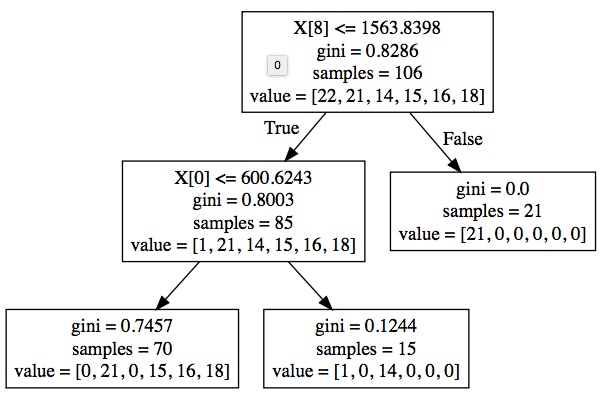

In [26]:
from IPython.display import Image
Image("images/5 gini.png")

In [27]:
clf = tree.DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=2)
clf.fit(data, target)

with open("decision_tree_entropy.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

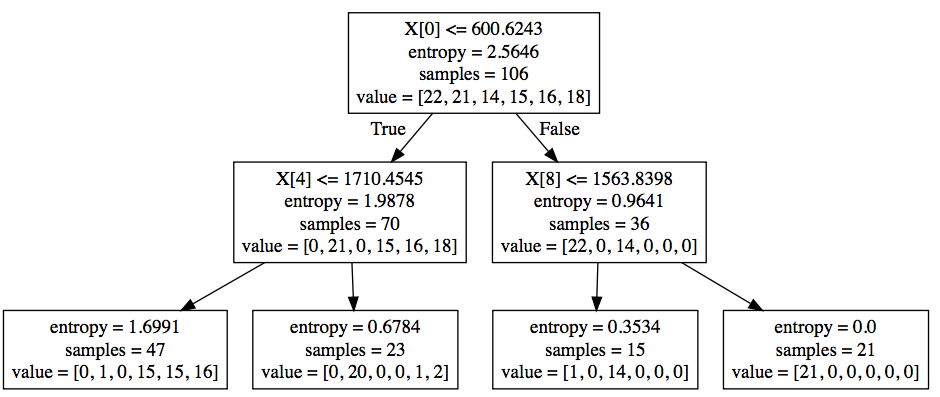

In [30]:
from IPython.display import Image
Image("images/5 entropy.png")

The two trees differ at all nodes except the first one. Considering just the set of lowest nodes, they are mostly the same, with the two right bottom most nodes being the same and the two/one left bottom most nodes differing.